<a href="https://colab.research.google.com/github/Anju-chavan/Image-colorization/blob/main/Image_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import random
import sys
import io
import os
import re
import keras
import urllib
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import LambdaCallback,ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
from keras.preprocessing.text import one_hot
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from sklearn import preprocessing
from keras.datasets import cifar10

import warnings
warnings.filterwarnings("ignore")

# Extract the class birds data.

Number of Training Instances: 5000
Number of Testing Instances: 1000
First 10 Images in the dataset:


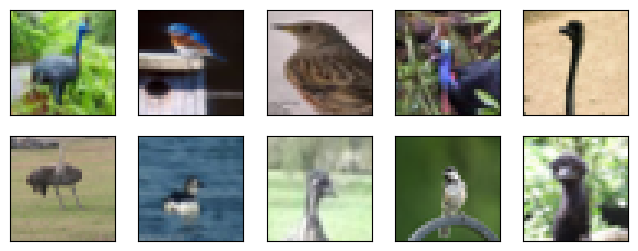

In [2]:
(trainFeatures, trainLabels), (testFeatures, testLabels) = cifar10.load_data()
numTrain, imgRows, imgCols, imgChannels = trainFeatures.shape
numTest, _, _, _ = testFeatures.shape
numClasses = len(np.unique(trainLabels))

trainBirdIndex = np.where(trainLabels[:]==2)[0]
trainBirdFeatures = trainFeatures[trainBirdIndex,::]
trainBirdLabels = trainLabels[trainBirdIndex,::]
print('Number of Training Instances:', trainBirdFeatures.shape[0])

testBirdIndex = (np.where(testLabels[:]==2)[0])
testBirdFeatures = testFeatures[testBirdIndex,::]
testBirdLabels = testLabels[testBirdIndex,::]
print('Number of Testing Instances:', testBirdFeatures.shape[0])

cifarDataX = np.concatenate((trainBirdFeatures, testBirdFeatures), axis=0)
cifarDataY = np.concatenate((trainBirdLabels, testBirdLabels),axis=0)

print('First 10 Images in the dataset:')
fig = plt.figure(figsize=(8, 3))
for i in range(0, 10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plt.imshow(cifarDataX[i])
plt.show()

# Choose pixels in the image.

In [3]:
totalPixels = cifarDataX.shape[0] * cifarDataX.shape[1] * cifarDataX.shape[2]
cifarDataFlatX = cifarDataX.reshape(totalPixels, imgChannels)
print('Total Pixels:', cifarDataFlatX.shape)

Total Pixels: (6144000, 3)


# K-Means Clustering to find 24 main colors.

In [4]:
colors = 24
kMeansModel = KMeans(n_clusters=colors)
kMeansModel = kMeansModel.fit(cifarDataFlatX)
mainColors = kMeansModel.cluster_centers_
print('RGB of', colors, 'Main Colors:')
print(mainColors)

RGB of 24 Main Colors:
[[ 54.22598276  58.72409384  55.91329776]
 [175.02127949 165.35421039 122.61602425]
 [244.9677937  246.19897409 244.89307186]
 [119.13778767 122.05925259 116.03642221]
 [189.69439832 190.90068586 187.96352579]
 [176.70535722 207.10100625 235.11706087]
 [ 40.59218822  40.80521044  30.3844114 ]
 [141.15984368 145.07713414 141.71015536]
 [132.37017159 171.10541557 213.19051625]
 [ 99.47866173 121.97433063  52.29335673]
 [221.31305085 218.31925977 209.08796948]
 [132.13029092 154.36076228  79.2954782 ]
 [111.72764969  85.65823007  55.00829311]
 [209.28031353 192.13651424 148.0874574 ]
 [153.05903936 137.73679796 106.57532632]
 [102.11768415 102.50031297  90.76147007]
 [ 57.6519716   98.00740409 138.24422578]
 [167.36177247 167.87937161 161.79684051]
 [136.58355368 114.97456751  78.30718811]
 [194.36047268 161.64356347  72.08483755]
 [ 78.79217971  81.9453982   72.53111837]
 [ 89.17996123 136.10185278 188.26146743]
 [ 74.19036288  72.00101246  38.01595732]
 [ 15.40182

In [5]:
predClusterLabels = kMeansModel.predict(cifarDataFlatX)
newCifarDataX = []
pixelMainColors = []
i = 0
while i<len(predClusterLabels):
    clusterLabel = predClusterLabels[i]
    newCifarDataX.append(mainColors[clusterLabel])
    oneHotEncoding = np.zeros(colors)
    oneHotEncoding[clusterLabel] = 1
    pixelMainColors.append(oneHotEncoding)
    i += 1
newCifarDataX = np.array(newCifarDataX)
newCifarDataX = np.reshape(newCifarDataX, (cifarDataX.shape[0], imgRows, imgCols, imgChannels)) 

pixelMainColors = np.array(pixelMainColors)
pixelMainColors = np.reshape(pixelMainColors, (cifarDataX.shape[0], imgRows*imgCols*colors))

Some 24 Colored Images in the dataset:


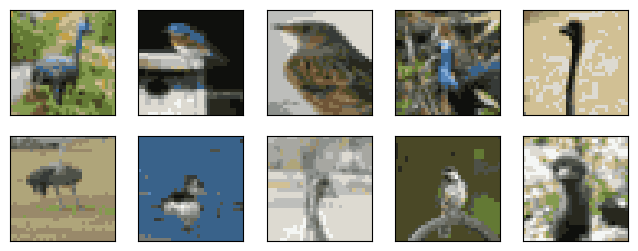

In [6]:
print('Some', colors,'Colored Images in the dataset:')
fig = plt.figure(figsize=(8, 3))
for i in range(0, 10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plt.imshow(newCifarDataX[i].astype(np.uint8))
plt.show()

# Obtain grayscale 32x32x1 images from the original 32x32x3 images.

In [7]:
grayTrainBirdFeatures = []
for i in range(trainBirdFeatures.shape[0]):
    grayTrainBirdFeatures.append(rgb2gray(trainBirdFeatures[i]))
grayTrainBirdFeatures = np.asarray(grayTrainBirdFeatures)

grayTestBirdFeatures = []
for i in range(testBirdFeatures.shape[0]):
    grayTestBirdFeatures.append(rgb2gray(testBirdFeatures[i]))
grayTestBirdFeatures = np.asarray(grayTestBirdFeatures)

First 10 Greyscale Training Images in the dataset:


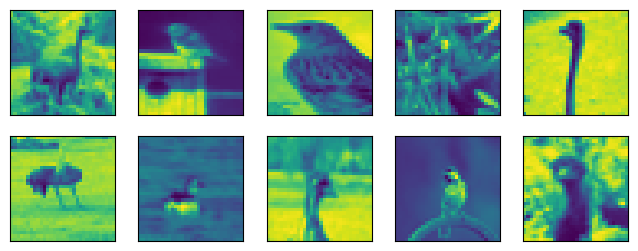

In [8]:
print('First 10 Greyscale Training Images in the dataset:')
fig = plt.figure(figsize=(8, 3))
for i in range(0, 10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plt.imshow(grayTrainBirdFeatures[i])
plt.show()

First 10 Greyscale Testing Images in the dataset:


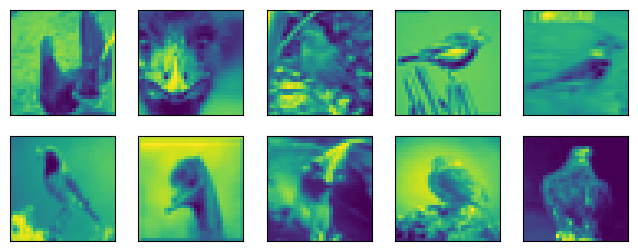

In [9]:
print('First 10 Greyscale Testing Images in the dataset:')
fig = plt.figure(figsize=(8, 3))
for i in range(0, 10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plt.imshow(grayTestBirdFeatures[i])
plt.show()

# Deep Convolutional Neural Network.

In [10]:
modelCNN = Sequential()
modelCNN.add(Conv2D(128, 
                    kernel_size=(5, 5), 
                    strides=1, 
                    input_shape=(32, 32, 1),
                    padding='same',
                    activation='relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2),
                          padding='same'))

modelCNN.add(Conv2D(128, 
                    kernel_size=(5, 5),
                    strides=1, 
                    padding='same',
                    activation='relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2),
                          padding='same'))

modelCNN.add(Flatten())

modelCNN.add(Dense(2048, 
                   activation = 'relu'))

modelCNN.add(Dense(1024*colors, 
                   activation = 'softmax'))

modelCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       409728    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2048)              1

In [11]:
adamOptimizer = keras.optimizers.Adam(lr=0.001)
modelCNN.compile(optimizer=adamOptimizer, 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

In [12]:
cnnModelFolder = str(colors) + ' Colors Model/'
cnnFileName = cnnModelFolder + "cnnmodel-{epoch:02d}-{loss:.4f}.hdf5"
cnnCheckpoint = ModelCheckpoint(cnnFileName, 
                                verbose = 1, 
                                save_best_only = False, 
                                save_weights_only = False, 
                                period = 1)

In [14]:
grayTrainBirdFeatures = np.reshape(grayTrainBirdFeatures, (len(grayTrainBirdFeatures), imgRows, imgCols, 1))
grayTestBirdFeatures = np.reshape(grayTestBirdFeatures, (len(grayTestBirdFeatures), imgRows, imgCols, 1))

In [13]:
epoch = 50
history = modelCNN.fit(grayTrainBirdFeatures, 
                       pixelMainColors[:grayTrainBirdFeatures.shape[0]],
                       epochs=epoch, 
                       shuffle=True,
                       verbose=1,
                       validation_split=0.1,
                       callbacks=[cnnCheckpoint])

Epoch 1/50
141/141 [==============================] - ETA: 0s - loss: 16597563392.0000 - accuracy: 0.0000e+00
Epoch 1: saving model to 24 Colors Model/cnnmodel-01-16597563392.0000.hdf5
141/141 [==============================] - 196s 1s/step - loss: 16597563392.0000 - accuracy: 0.0000e+00 - val_loss: 105685958656.0000 - val_accuracy: 0.0000e+00
Epoch 2/50
141/141 [==============================] - ETA: 0s - loss: 1107563773952.0000 - accuracy: 0.0000e+00
Epoch 2: saving model to 24 Colors Model/cnnmodel-02-1107563773952.0000.hdf5
141/141 [==============================] - 208s 1s/step - loss: 1107563773952.0000 - accuracy: 0.0000e+00 - val_loss: 3212883787776.0000 - val_accuracy: 0.0000e+00
Epoch 3/50
141/141 [==============================] - ETA: 0s - loss: 9542123388928.0000 - accuracy: 0.0000e+00
Epoch 3: saving model to 24 Colors Model/cnnmodel-03-9542123388928.0000.hdf5
141/141 [==============================] - 212s 2s/step - loss: 9542123388928.0000 - accuracy: 0.0000e+00 - val_

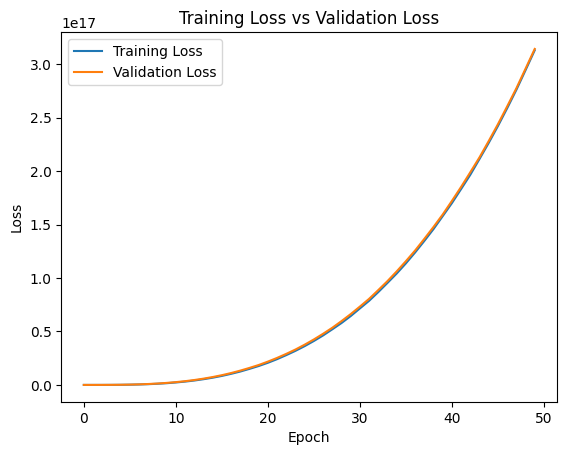

In [15]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [16]:
modelFiles = os.listdir(cnnModelFolder)
finalCNNModelFile = '' 
minCNNLoss = None
for modelFile in modelFiles:
    if modelFile.startswith('cnnmodel'):
        idx = modelFile.rindex('-')
        modelLoss = modelFile[idx+1:len(modelFile)-5]
        if minCNNLoss==None or modelLoss<minCNNLoss:
            minCNNLoss = modelLoss
            finalCNNModelFile = modelFile
print('Best CNN Model with Less Loss:', finalCNNModelFile)

Best CNN Model with Less Loss: cnnmodel-05-102926500495360.0000.hdf5


In [17]:
bestCNNModel = keras.models.load_model(cnnModelFolder + finalCNNModelFile)

In [18]:
predictedCNNTest = bestCNNModel.predict(grayTestBirdFeatures[:10])

1/1 [==============================] - 0s 385ms/step


In [19]:
predictedTestImages = np.reshape(predictedCNNTest,(10240, colors))
outputImages = []
for pixel in predictedTestImages:
    outputImages.append(mainColors[np.argmax(pixel)])
outputImages = np.reshape(outputImages,(10,32,32,3))

  Original Image        CNN Colored Image       Greyscale Image


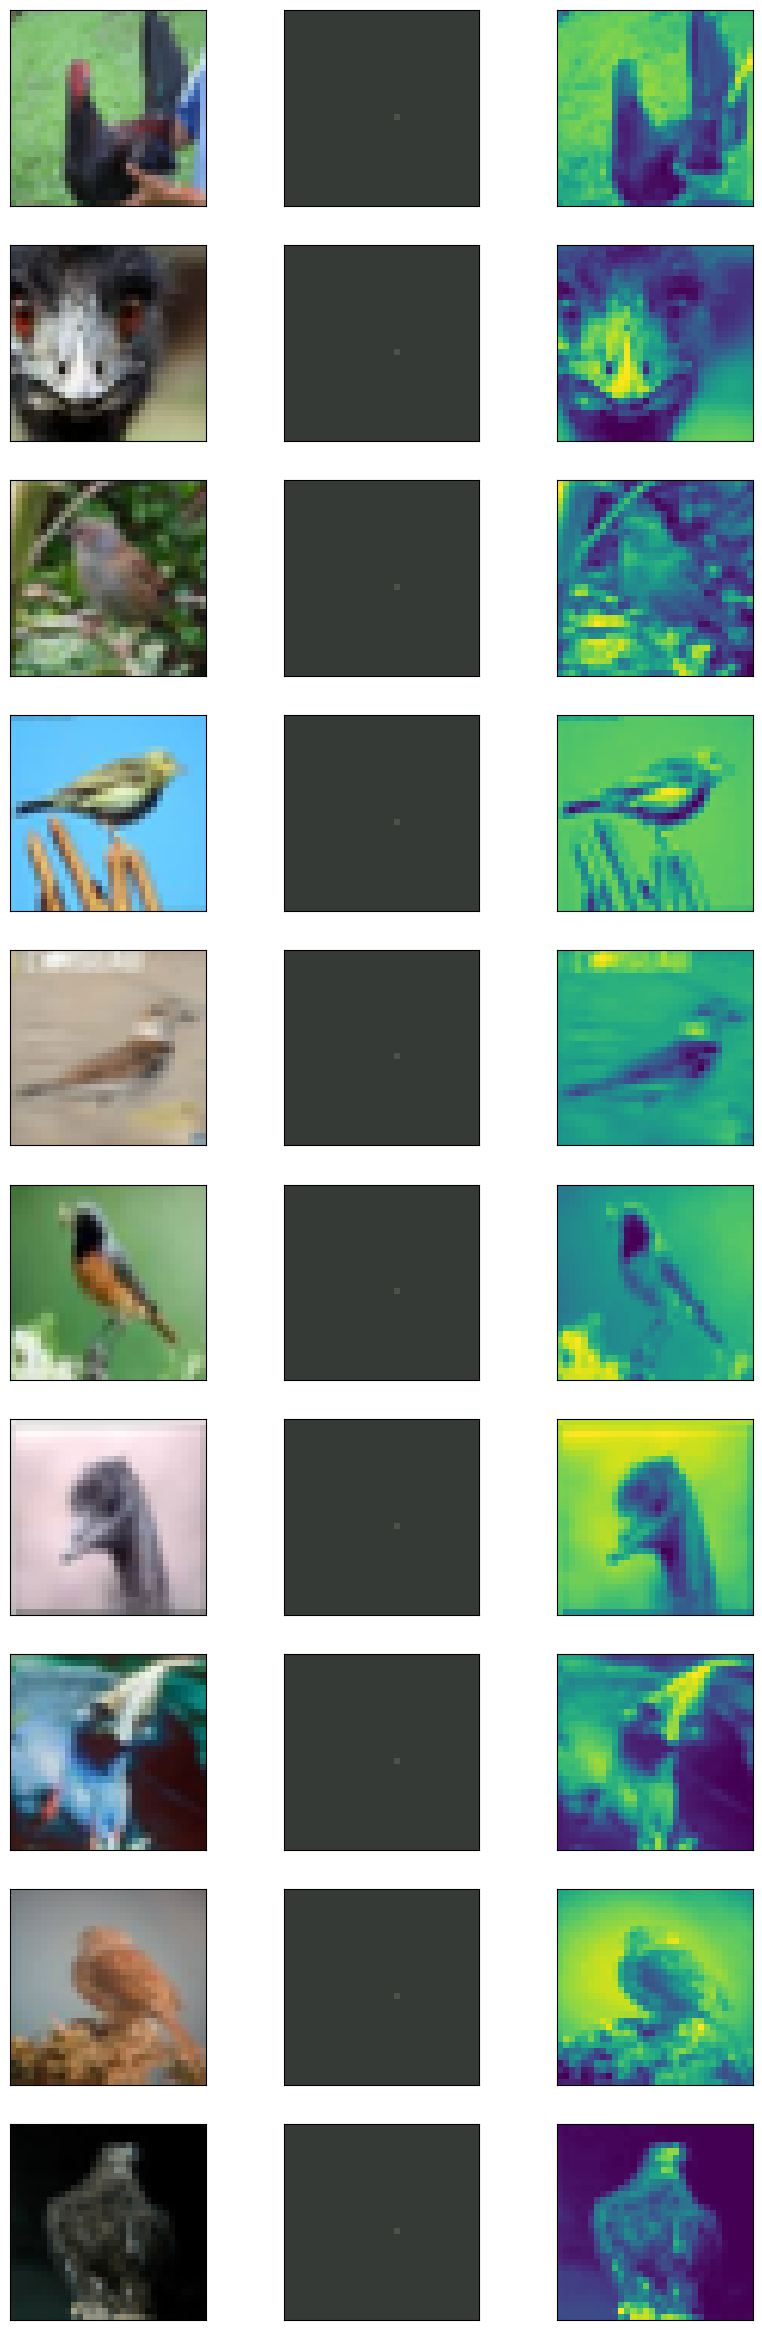

In [20]:
print('  Original Image        CNN Colored Image       Greyscale Image')
fig = plt.figure(figsize=(10, 30))
for i in range(0, 30):
    ax = fig.add_subplot(10, 3, i+1, xticks=[], yticks=[])
    if i%3==0:
        plt.imshow(testBirdFeatures[int(i/3)])
    elif i%3==1:
        plt.imshow(outputImages[int((i-1)/3)].astype(np.uint8))
    else:
        plt.imshow(grayTestBirdFeatures[int((i-2)/3)].reshape(32, 32))
plt.show()